In [5]:
# If needed, install (uncomment and run once):
# !pip install -q "qiskit>=2.1" qiskit-aer

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector


In [ ]:
plt.rcParams["font.family"] = "cmr10"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.formatter.use_mathtext"] = True

def sv_from_circ(circ: QuantumCircuit) -> np.ndarray:
    # Qiskit uses little-endian basis (q0 is LSB in the bitstring).
    sv = Statevector(circ)
    return np.asarray(sv, dtype=np.complex128)

class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")

        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk radius ∝ sqrt(probability) → area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow (angle in radians)
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()


In [7]:
def inc3_gate():
    """
    In-place increment by 1 modulo 8 on [q0 (LSB), q1, q2 (MSB)].
    Carry cascade via control-on-0 using the X-sandwich trick.
    """
    qc = QuantumCircuit(3, name="INC+1")
    # Flip q0
    qc.x(0)
    # Flip q1 iff q0 == 0
    qc.x(0); qc.cx(0, 1); qc.x(0)
    # Flip q2 iff q0 == 0 AND q1 == 0
    qc.x(0); qc.x(1); qc.ccx(0, 1, 2); qc.x(1); qc.x(0)
    return qc

def dec3_gate():
    """
    In-place decrement by 1 modulo 8 on [q0 (LSB), q1, q2 (MSB)].
    Borrow cascade with positive controls.
    """
    qc = QuantumCircuit(3, name="DEC-1")
    qc.x(0)           # flip q0
    qc.cx(0, 1)       # flip q1 iff q0 == 1
    qc.ccx(0, 1, 2)   # flip q2 iff q0 == 1 and q1 == 1
    return qc

inc = inc3_gate()
dec = dec3_gate()


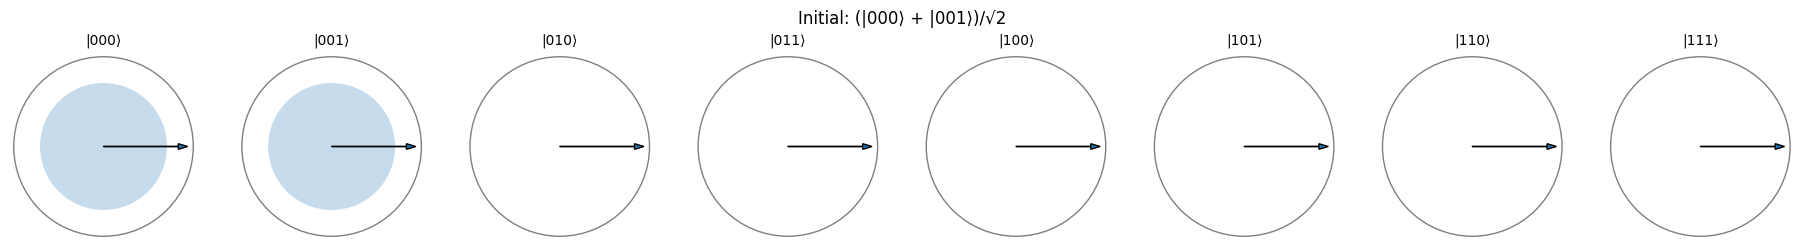

In [8]:
# Choose a superposition that visibly moves under +=1 / -=1.
# We'll use H on the LSB only: (|000⟩ + |001⟩) / √2
prep = QuantumCircuit(3, name="prep (H on LSB)")
prep.h(0)

sv_init = sv_from_circ(prep)
QubitSystem(sv_init, label="Initial: (|000⟩ + |001⟩)/√2").viz_circle()


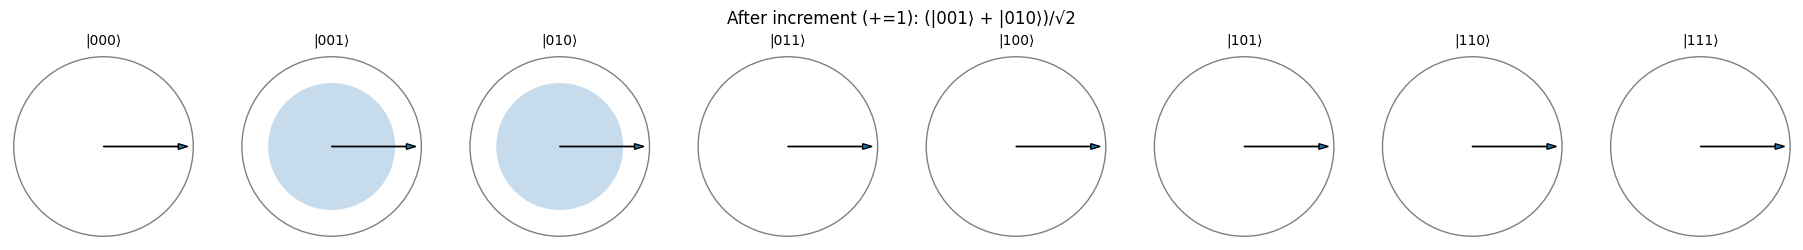

In [9]:
circ_inc = prep.compose(inc)
sv_after_inc = sv_from_circ(circ_inc)
QubitSystem(sv_after_inc, label="After increment (+=1): (|001⟩ + |010⟩)/√2").viz_circle()


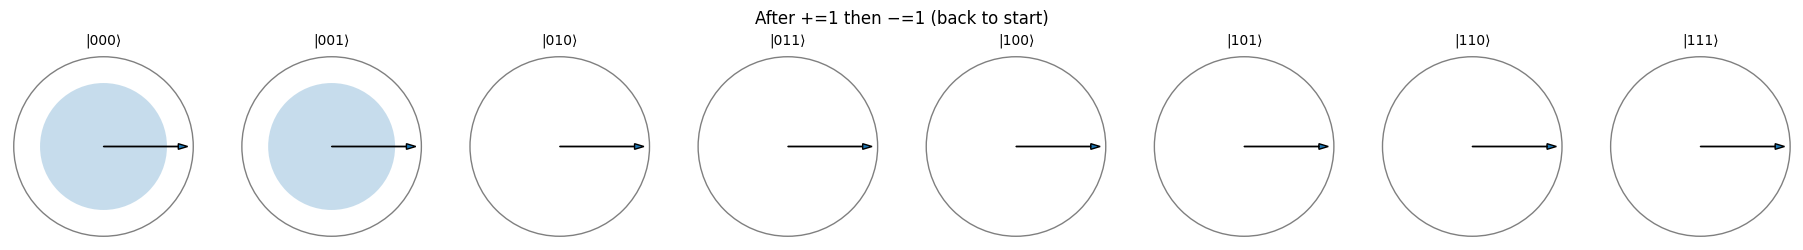

In [10]:
circ_dec_after_inc = circ_inc.compose(dec)  # +=1 then −=1 (net: identity)
sv_after_inc_dec = sv_from_circ(circ_dec_after_inc)
QubitSystem(sv_after_inc_dec, label="After +=1 then −=1 (back to start)").viz_circle()


In [11]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

# Two's complement interpretation on 3 bits: range [-4, +3]
def signed_value(bits3: int) -> int:
    return bits3 - 8 if (bits3 & 0b100) else bits3

# Make a circuit that prepares a given 3-bit basis state |b2 b1 b0⟩
def bits_to_circ(x: int) -> QuantumCircuit:
    qc = QuantumCircuit(3)
    if x & 1: qc.x(0)
    if x & 2: qc.x(1)
    if x & 4: qc.x(2)
    return qc

# Print the basis index before/after a circuit, both unsigned and signed
def show_before_after(label, prep_circ: QuantumCircuit, op_circ: QuantumCircuit = None):
    sv_in = Statevector.from_instruction(prep_circ).data
    i_in  = int(np.argmax(np.abs(sv_in)))
    text = [f"{label} — BEFORE: bits={i_in:03b}, unsigned={i_in}, signed={signed_value(i_in)}"]
    if op_circ is not None:
        sv_out = Statevector.from_instruction(prep_circ.compose(op_circ)).data
        i_out  = int(np.argmax(np.abs(sv_out)))
        text += [f"{label} — AFTER:  bits={i_out:03b}, unsigned={i_out}, signed={signed_value(i_out)}"]
    print("\n".join(text))


Overflow (INC) — BEFORE: bits=111, unsigned=7, signed=-1
Overflow (INC) — AFTER:  bits=000, unsigned=0, signed=0


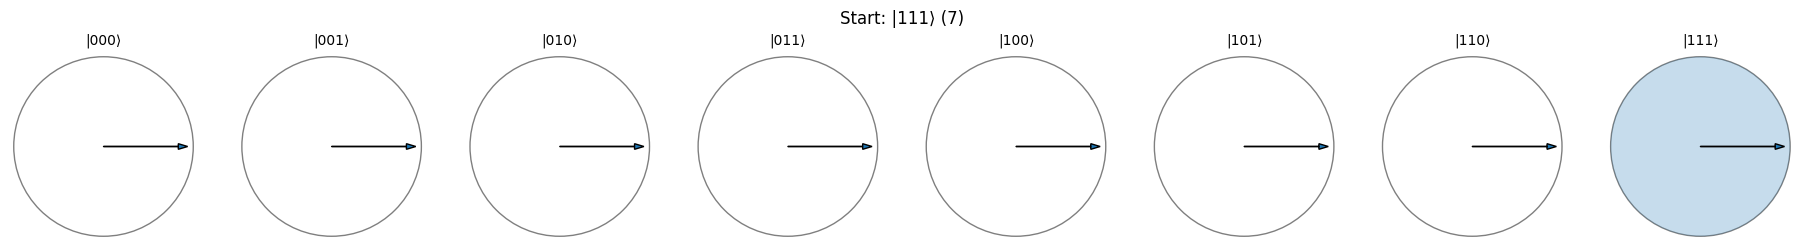

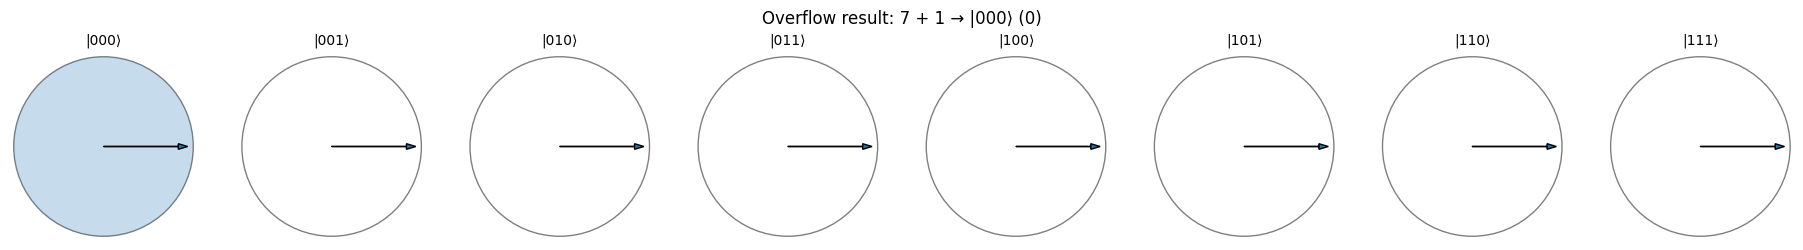

In [12]:
# Uses the INC circuit from Task 1.1 (variable 'inc')
prep_7 = bits_to_circ(0b111)   # |111⟩ (7)
show_before_after("Overflow (INC)", prep_7, inc)

# Optional circle plots if QubitSystem is available:
try:
    QubitSystem(sv_from_circ(prep_7), "Start: |111⟩ (7)").viz_circle()
    QubitSystem(sv_from_circ(prep_7.compose(inc)), "Overflow result: 7 + 1 → |000⟩ (0)").viz_circle()
except NameError:
    pass


Underflow (DEC) — BEFORE: bits=000, unsigned=0, signed=0
Underflow (DEC) — AFTER:  bits=111, unsigned=7, signed=-1


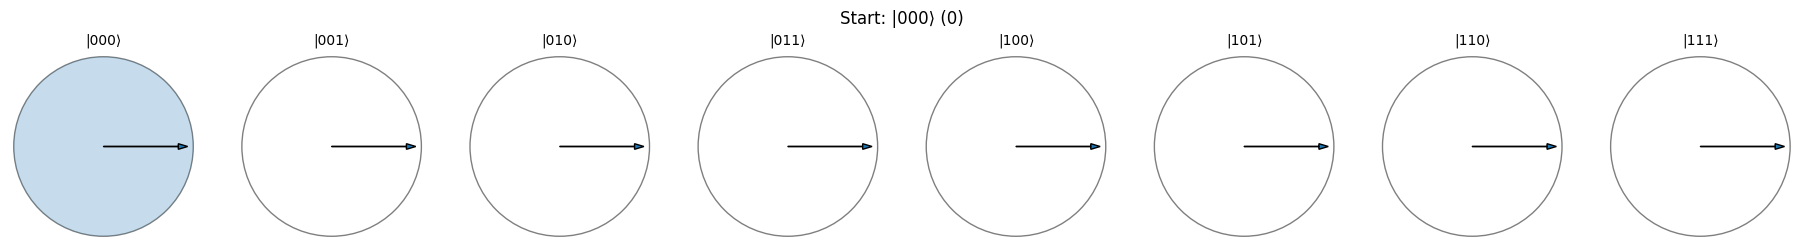

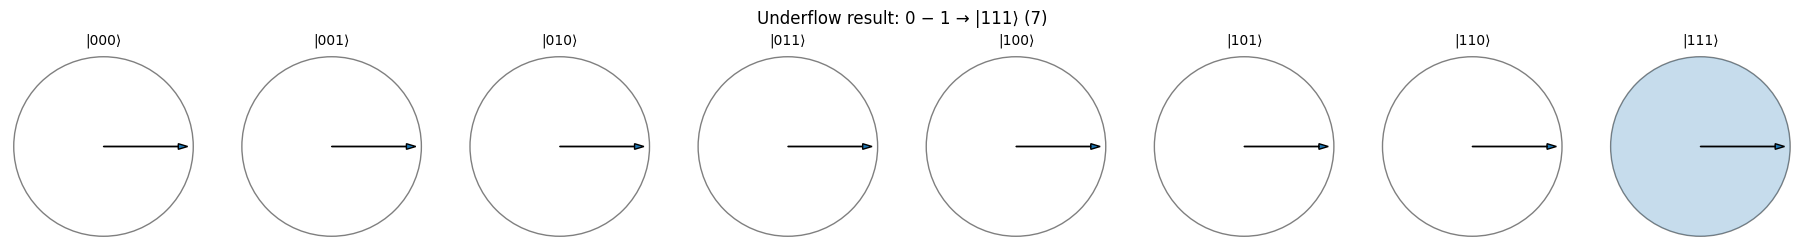

In [14]:
# Uses the DEC circuit from Task 1.1 (variable 'dec')
prep_0 = bits_to_circ(0b000)   # |000⟩ (0)
show_before_after("Underflow (DEC)", prep_0, dec)

# Optional circle plots
try:
    QubitSystem(sv_from_circ(prep_0), "Start: |000⟩ (0)").viz_circle()
    QubitSystem(sv_from_circ(prep_0.compose(dec)), "Underflow result: 0 − 1 → |111⟩ (7)").viz_circle()
except NameError:
    pass


Signed example (−1 + 1) — BEFORE: bits=111, unsigned=7, signed=-1
Signed example (−1 + 1) — AFTER:  bits=000, unsigned=0, signed=0
Signed example (−4 − 1) — BEFORE: bits=100, unsigned=4, signed=-4
Signed example (−4 − 1) — AFTER:  bits=011, unsigned=3, signed=3


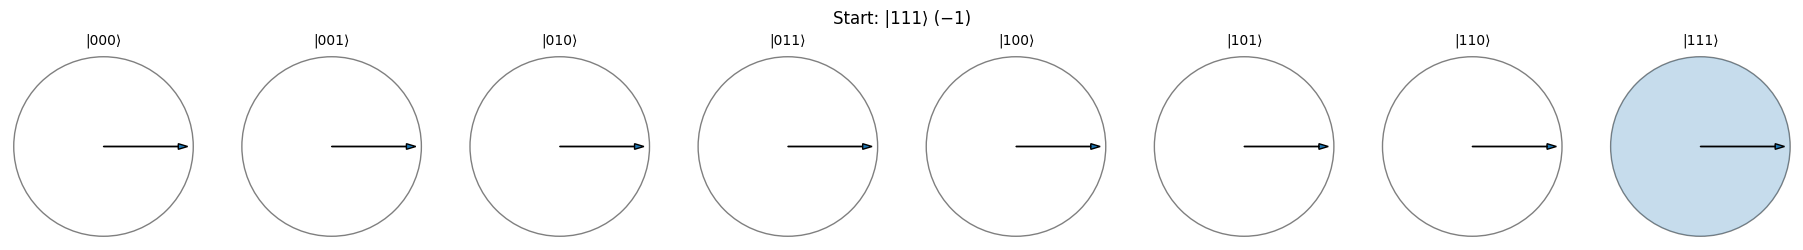

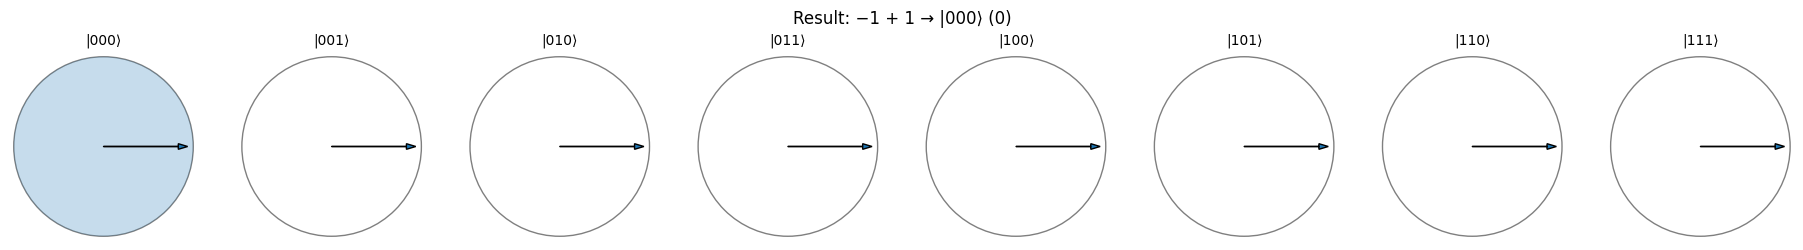

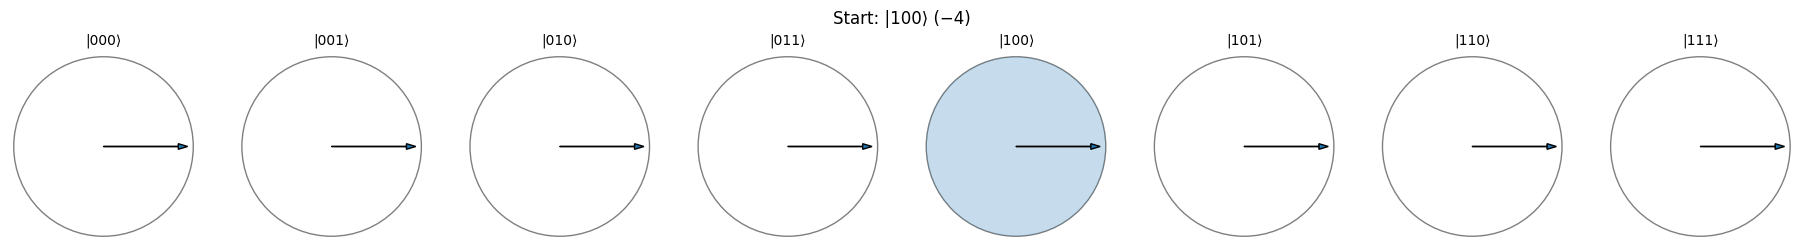

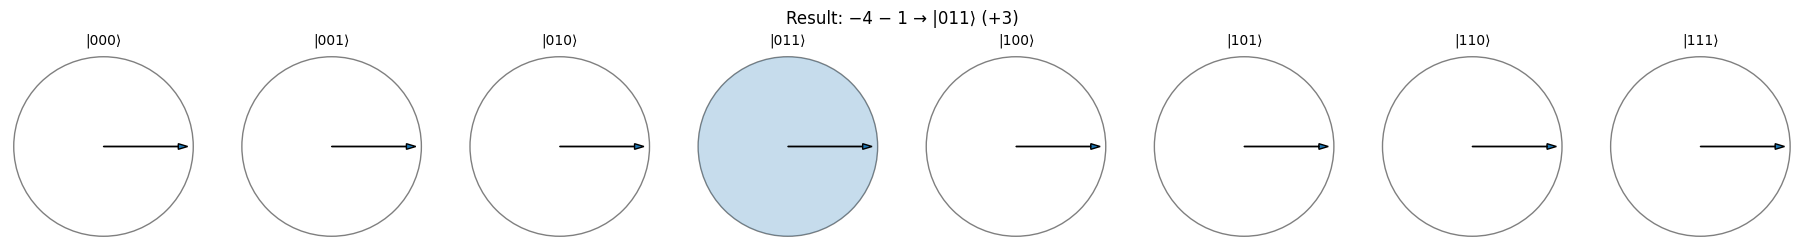

In [15]:
# Example 1: start at −1 (111), increment → 0 (000)
prep_neg1 = bits_to_circ(0b111)
show_before_after("Signed example (−1 + 1)", prep_neg1, inc)

# Example 2: start at −4 (100), decrement → +3 (011)
prep_neg4 = bits_to_circ(0b100)
show_before_after("Signed example (−4 − 1)", prep_neg4, dec)

# Optional circle plots
try:
    QubitSystem(sv_from_circ(prep_neg1), "Start: |111⟩ (−1)").viz_circle()
    QubitSystem(sv_from_circ(prep_neg1.compose(inc)), "Result: −1 + 1 → |000⟩ (0)").viz_circle()

    QubitSystem(sv_from_circ(prep_neg4), "Start: |100⟩ (−4)").viz_circle()
    QubitSystem(sv_from_circ(prep_neg4.compose(dec)), "Result: −4 − 1 → |011⟩ (+3)").viz_circle()
except NameError:
    pass


In [ ]:
import numpy as np
from qiskit import QuantumCircuit

def qft4_dagger(no_swaps: bool = True) -> QuantumCircuit:
    """
    4-qubit QFT† (inverse QFT) in the 'figure style':
      - Controlled phases use NEGATIVE angles: −π/2, −π/4, −π/8
      - For each target qubit: apply CPs first, THEN H on that target
      - Optional final bit-reversal swaps (q0<->q3, q1<->q2)
    Wires (Qiskit little-endian): q0 (LSB) ... q3 (MSB)
    """
    qc = QuantumCircuit(4, name="QFT† (figure-style)")

    # Column 1: target q3 gets CP from q2,q1,q0, then H(q3)
    qc.cp(-np.pi/2, 2, 3)   # control q2 -> target q3
    qc.cp(-np.pi/4, 1, 3)   # control q1 -> target q3
    qc.cp(-np.pi/8, 0, 3)   # control q0 -> target q3
    qc.h(3)
    qc.barrier()

    # Column 2: target q2 gets CP from q1,q0, then H(q2)
    qc.cp(-np.pi/2, 1, 2)   # control q1 -> target q2
    qc.cp(-np.pi/4, 0, 2)   # control q0 -> target q2
    qc.h(2)
    qc.barrier()

    # Column 3: target q1 gets CP from q0, then H(q1)
    qc.cp(-np.pi/2, 0, 1)   # control q0 -> target q1
    qc.h(1)
    qc.barrier()

    # Column 4: only H(q0)
    qc.h(0)
    qc.barrier()

    # Final bit-reversal swaps (as drawn)
    qc.swap(0, 3)
    qc.swap(1, 2)

    return qc


def qft4(no_swaps: bool = True) -> QuantumCircuit:
    """
    Forward QFT — just the inverse of QFT† above.
    (Positive-angle, H-then-CP equivalent up to ordering.)
    """
    return qft4_dagger(no_swaps=no_swaps).inverse()


def iqft4(no_swaps: bool = True) -> QuantumCircuit:
    """
    Inverse QFT (i.e., QFT†). For convenience, expose it directly.
    """
    return qft4_dagger(no_swaps=no_swaps)



In [49]:
def basis_4q(k: int) -> QuantumCircuit:
    """Prepare |k> on 4 qubits (little-endian)."""
    qc = QuantumCircuit(4, name=f"|{k:04b}⟩")
    if k & 1: qc.x(0)
    if k & 2: qc.x(1)
    if k & 4: qc.x(2)
    if k & 8: qc.x(3)
    return qc

k = 3  # choose frequency 0..15
prep_k = basis_4q(k)
prep_signal = prep_k.compose(iqft4(no_swaps=True))  # produces phase-ramp (complex sinusoid)


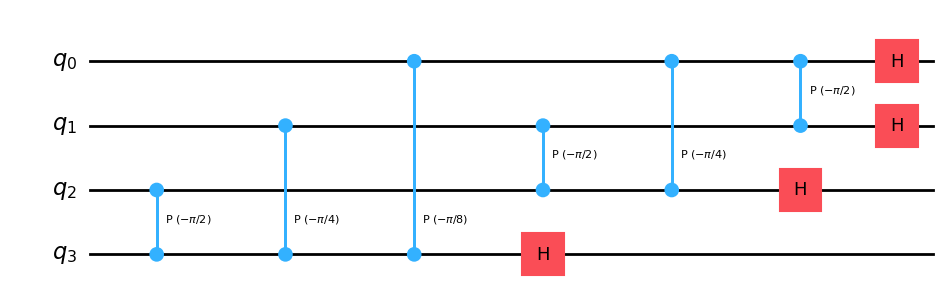

In [52]:
prep_signal.decompose().draw("mpl")
qft4_dagger(no_swaps=True).draw("mpl")


# TASK 2.2

In [43]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# If you've already defined qft4(), iqft4(), sv_from_circ(), and QubitSystem earlier, reuse them.

def qft4(no_swaps: bool = True) -> QuantumCircuit:
    qc = QuantumCircuit(4, name="QFT4")
    qc.h(3); qc.cp(np.pi/2, 2, 3); qc.cp(np.pi/4, 1, 3); qc.cp(np.pi/8, 0, 3)
    qc.h(2); qc.cp(np.pi/2, 1, 2); qc.cp(np.pi/4, 0, 2)
    qc.h(1); qc.cp(np.pi/2, 0, 1)
    qc.h(0)
    if not no_swaps: qc.swap(0,3); qc.swap(1,2)
    return qc

def iqft4(no_swaps: bool = True) -> QuantumCircuit:
    return qft4(no_swaps=no_swaps).inverse()

def basis_4q(k: int) -> QuantumCircuit:
    qc = QuantumCircuit(4, name=f"|{k:04b}⟩")
    if k & 1: qc.x(0)
    if k & 2: qc.x(1)
    if k & 4: qc.x(2)
    if k & 8: qc.x(3)
    return qc

k = 3  # choose a frequency 0..15
prep = basis_4q(k).compose(iqft4(no_swaps=True))   # produces complex sinusoid (phase ramp)
sv_in = np.asarray(Statevector(prep), dtype=np.complex128)


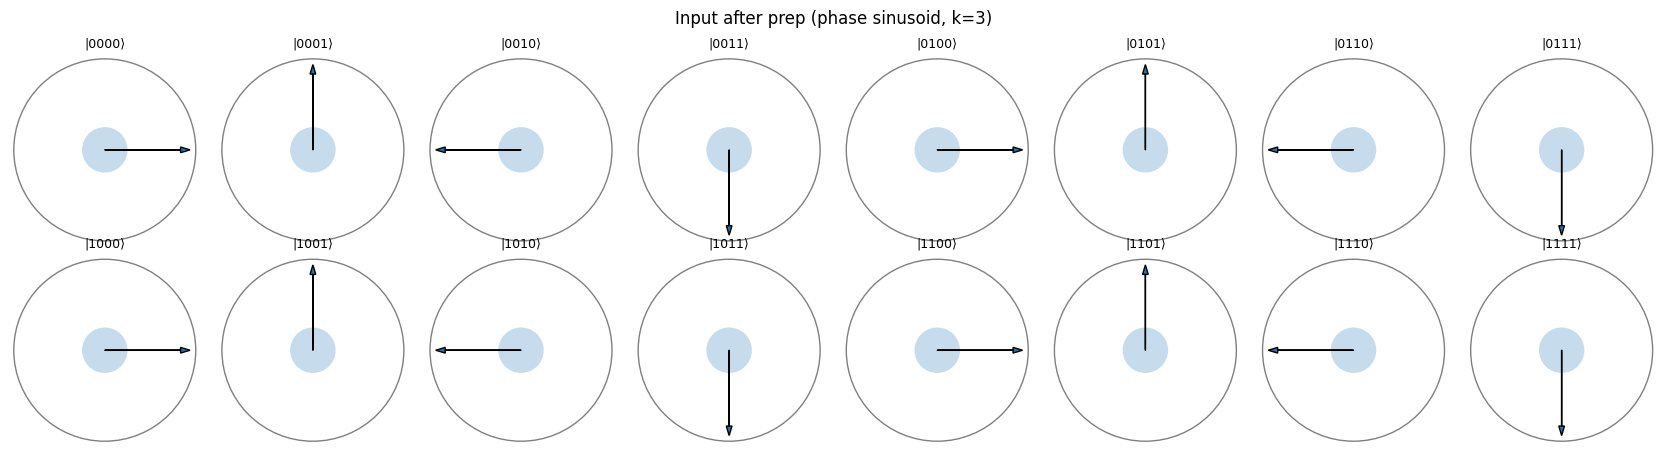

In [44]:
# Circle-notation helper (works for any n). If you already defined it earlier, skip redefining.
import math, matplotlib.pyplot as plt

class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label; self.set_statevector(statevector)
    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        n_states = sv.size; n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states: raise ValueError("Length must be power of 2.")
        norm = np.linalg.norm(sv); 
        if norm != 0 and not np.isclose(norm,1.0): sv = sv / norm
        self.n_qubits, self.n_states = n_qubits, n_states
        self.amps, self.prob, self.phase = sv, np.abs(sv)**2, np.angle(sv)
    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.1):
        cols = max(1, min(max_cols, self.n_states)); rows = int(math.ceil(self.n_states/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols*figsize_scale, rows*(figsize_scale+0.2)))
        axes = np.atleast_2d(axes)
        def bitstr(i, n): return format(i, f"0{n}b")
        for idx in range(rows*cols):
            r,c = divmod(idx, cols); ax = axes[r,c]; ax.set_aspect("equal"); ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")
            if idx >= self.n_states: ax.set_visible(False); continue
            ax.add_patch(plt.Circle((0.5,0.5), 0.48, fill=False, lw=1.0, alpha=0.5))
            radius = 0.48*np.sqrt(self.prob[idx]); ax.add_patch(plt.Circle((0.5,0.5), radius, alpha=0.25))
            angle = self.phase[idx]; L = 0.45
            x2 = 0.5 + L*np.cos(angle); y2 = 0.5 + L*np.sin(angle)
            ax.arrow(0.5,0.5, x2-0.5, y2-0.5, head_width=0.03, head_length=0.05, length_includes_head=True)
            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=9)
        fig.suptitle(self.label, fontsize=12); plt.tight_layout(); plt.show()

QubitSystem(sv_in, label=f"Input after prep (phase sinusoid, k={k})").viz_circle(max_cols=8)


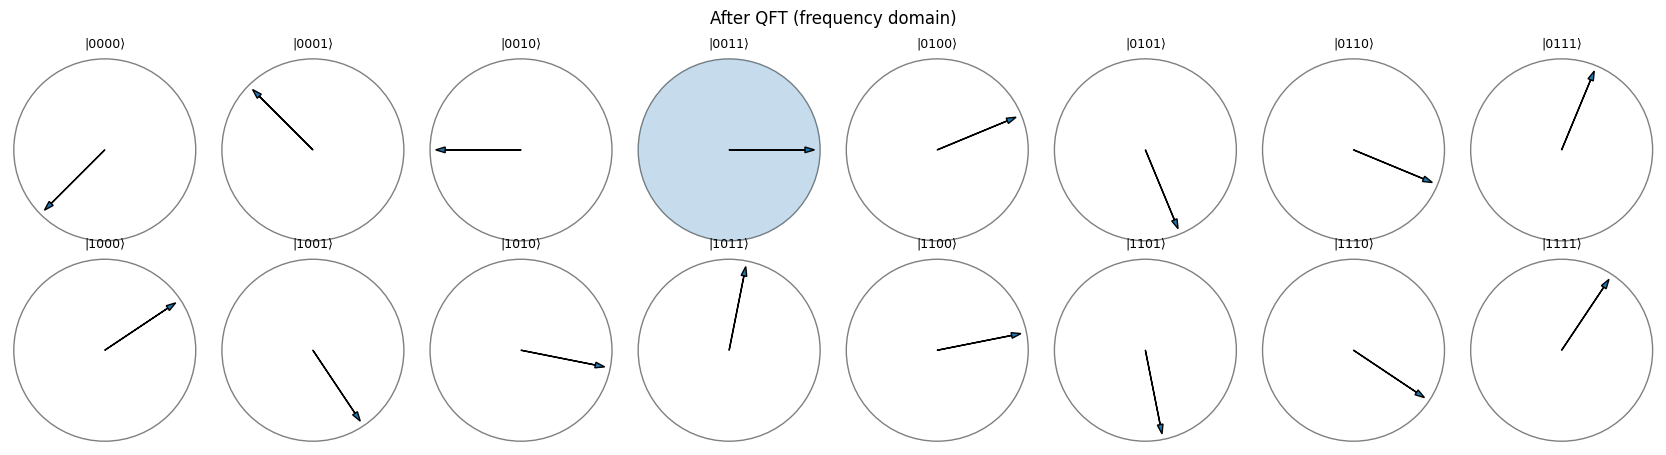

In [46]:
qft = qft4(no_swaps=True)
full = prep.compose(qft)
sv_out = np.asarray(Statevector(full), dtype=np.complex128)

QubitSystem(sv_out, label="After QFT (frequency domain)").viz_circle(max_cols=8)


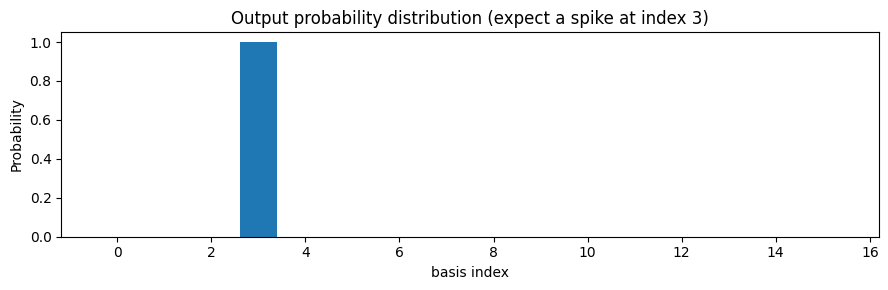

Top components: [(3, 0.9999999999999987), (5, 2.3801593248031538e-34), (7, 2.3801593248031538e-34), (1, 9.071053470133419e-35), (0, 9.071053470133416e-35)]


In [47]:
probs_out = np.abs(sv_out)**2
plt.figure(figsize=(9,3))
plt.bar(range(16), probs_out)
plt.title(f"Output probability distribution (expect a spike at index {k})")
plt.xlabel("basis index"); plt.ylabel("Probability"); plt.tight_layout(); plt.show()

print("Top components:", sorted([(i,float(p)) for i,p in enumerate(probs_out)], key=lambda t:-t[1])[:5])
